## Generating Training and Test Data for the Mass-Spring-Damper Model 

In [27]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import cantera as ct
from scipy.integrate import solve_ivp

import pyDOE

from PCAfold import PCA as PCAA

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [28]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data/MSD_100Cases/Orig'

NICs           = 100
POD_NAME       = 'All'
iVar           = 0

if (POD_NAME == 'All'):
    NPODsFinal = 2
    PODType    = 'All'
else:
    NPODsFinal = 2
    PODType    = 'OneByOne'
try:
    os.makedirs(OutputDir+'/'+str(PODType))
except:
    pass


Vars   = ['x', 'v']
NVars  = len(Vars)

ValidPerc = 0.2

In [29]:
if (POD_NAME == 'All'):
    
    Cols   = []
    NewFlg = True
    for iC in range(NICs):

        FileName             = OutputDir+'/train/ext/y.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data[Vars]


        for iVar in range(NVars):
            if (np.abs( (DataTemp[Vars[iVar]][0] - DataTemp[Vars[iVar]][len(Data)-1])/DataTemp[Vars[iVar]][0] ) > 1.e-3): 
                DataICTemp  = Data[Vars].iloc[0]
                if (NewFlg):
                    DataInput        = DataTemp
                    DataIC           = DataICTemp
                    NewFlg           = False
                else:
                    DataInput        = pd.concat([DataInput, DataTemp[Vars]], axis=1)
                    DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
                #Cols.append(str(iC+1))
                Cols = Cols+[str(iC+1)+'_'+Vars[iVar]]

    tVec              = Data['t']
    
    yMat              = DataInput.to_numpy()
    
else:
    
    Cols   = []
    NewFlg = True
    for iC in range(NICs):

        FileName             = OutputDir+'/train/ext/y.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data[Vars[iVar]]

        if (np.abs( (DataTemp[0] - DataTemp[len(Data)-1])/DataTemp[0] ) > 1.e-3):
            DataICTemp  = Data[Vars].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))

    tVec              = Data['t']
    DataInput.columns = Cols

    yMat              = DataInput.to_numpy()
    
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

In [30]:
ICs = DataIC.to_numpy()

In [31]:
ICs.shape

(200, 2)

(0.0, 10.0)

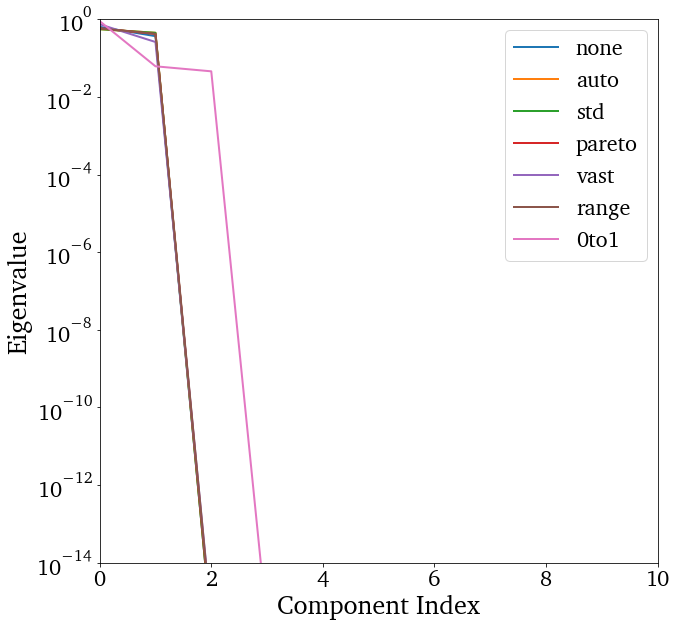

In [32]:
NPODs      = 64
ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
#'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

plt.figure(figsize=(10,10))
for j, Scaling in enumerate(ScalingVec):

    pca        = PCAA(yMat, scaling=Scaling, n_components=int(NPODs))
    C          = pca.X_center
    D          = pca.X_scale
    A          = pca.A[:,0:NPODs].T
    L          = pca.L
    AT         = A.T

    plt.plot(L, label=Scaling)
    
plt.ylim([1.e-14, 1.e0])
plt.xlabel('Component Index')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
plt.xlim([0,10])

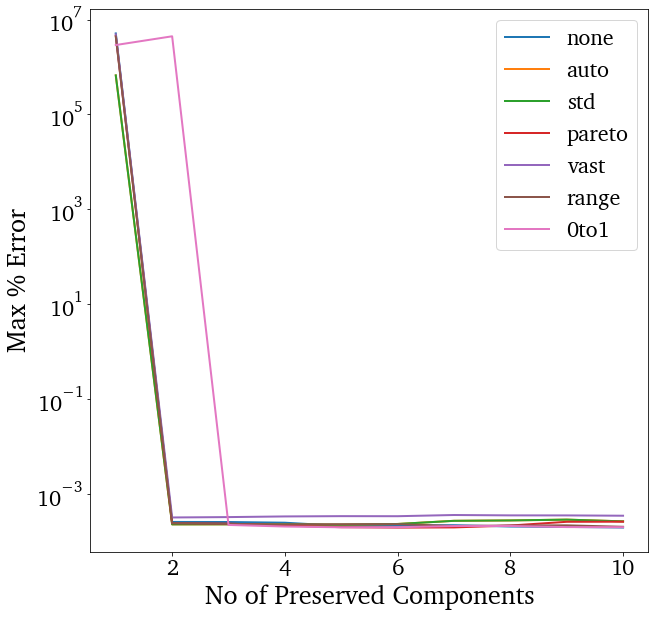

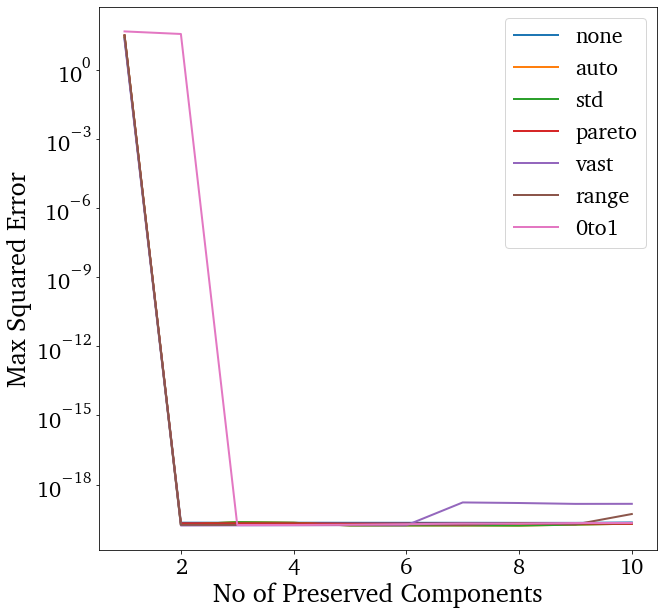

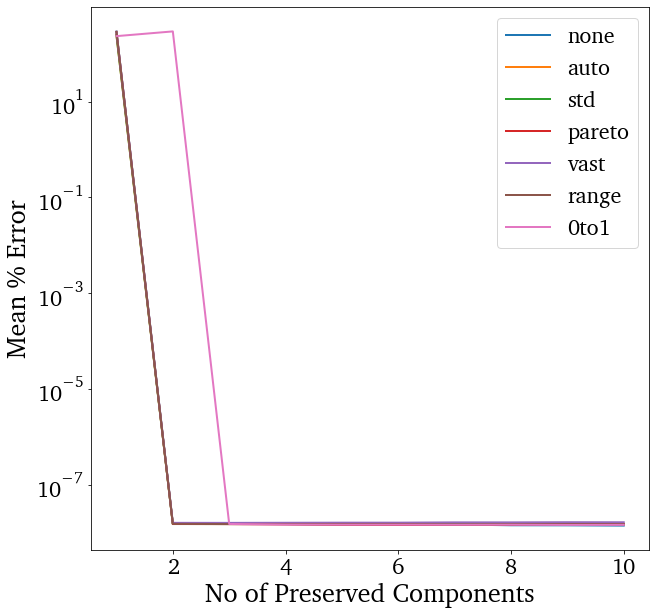

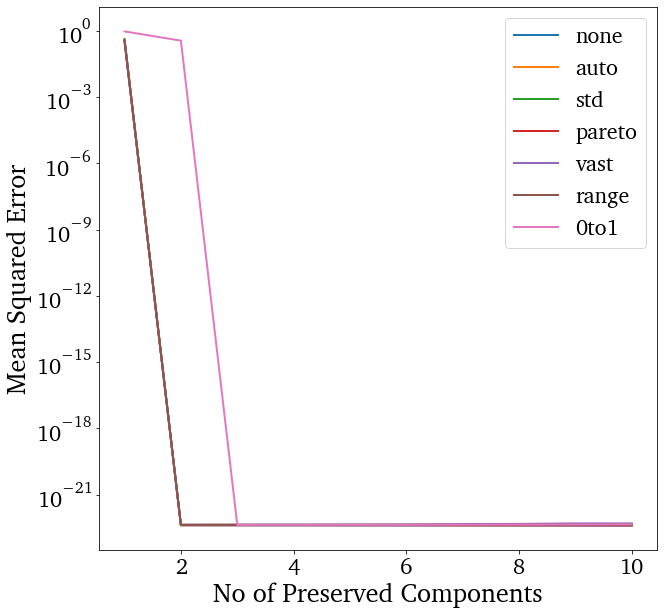

In [33]:
NPODsVec   = np.arange(1,11,1)
ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
#'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

MaxPerc    = np.zeros((len(NPODsVec), len(ScalingVec)))
MaxSE      = np.zeros((len(NPODsVec), len(ScalingVec)))
MeanPerc   = np.zeros((len(NPODsVec), len(ScalingVec)))
MSE        = np.zeros((len(NPODsVec), len(ScalingVec)))
for i, NPODs in enumerate(NPODsVec):
    #print('NPODs = ', NPODs)
    
    for j, Scaling in enumerate(ScalingVec):

        pca        = PCAA(yMat, scaling=Scaling, n_components=int(NPODs))
        C          = pca.X_center
        D          = pca.X_scale
        A          = pca.A[:,0:NPODs].T
        L          = pca.L
        AT         = A.T

        yMat_pca   = ((yMat - C)/D).dot(AT)
        yMat_      = (yMat_pca.dot(A))*D + C
        
        MaxPerc[i,j]    = np.max(abs((yMat - yMat_)/yMat)*100)
        MaxSE[i,j]      = np.max((yMat - yMat_)**2)
        MeanPerc[i,j]   = np.mean(abs((yMat - yMat_)/yMat)*100)
        MSE[i,j]        = np.mean((yMat - yMat_)**2)

plt.figure(figsize=(10,10))
plt.plot(NPODsVec, MaxPerc, label=ScalingVec)
plt.xlabel('No of Preserved Components')
plt.ylabel('Max % Error')
plt.legend()
plt.yscale('log')

plt.figure(figsize=(10,10))
plt.plot(NPODsVec, MaxSE, label=ScalingVec)
plt.xlabel('No of Preserved Components')
plt.ylabel('Max Squared Error')
plt.legend()
plt.yscale('log')

plt.figure(figsize=(10,10))
plt.plot(NPODsVec, MeanPerc, label=ScalingVec)
plt.xlabel('No of Preserved Components')
plt.ylabel('Mean % Error')
plt.legend()
plt.yscale('log')

plt.figure(figsize=(10,10))
plt.plot(NPODsVec, MSE, label=ScalingVec)
plt.xlabel('No of Preserved Components')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.yscale('log')

In [34]:
pca        = PCAA(yMat, scaling='pareto', n_components=NPODsFinal, nocenter=False)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:NPODsFinal].T
L          = pca.L
AT         = A.T
print('[PCA] Shape of A        = ', A.shape)
print('[PCA] ')

[PCA] Shape of A        =  (2, 400)
[PCA] 


In [35]:
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/')
except:
    pass

FileName    = OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/A.csv'
np.savetxt(FileName, A, delimiter=',')

FileName    = OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/C.csv'
np.savetxt(FileName, C, delimiter=',')

FileName    = OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/D.csv'
np.savetxt(FileName, D, delimiter=',')

In [36]:
#yMat_pca    = pca.transform(yMat, nocenter=False)
yMat_pca   = ((yMat - C)/D).dot(AT)

yMat_      = (yMat_pca.dot(A))*D + C
print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

[PCA] Shape of yMat_pca =  (500, 2)
[PCA]  Max % Error =  0.00023736024966591358
[PCA]  Max      SE =  2.11248825804909e-20
[PCA] Mean % Error =  1.5246691007207038e-08
[PCA]          MSE =  4.1224516848381167e-23


ValueError: shape mismatch: objects cannot be broadcast to a single shape

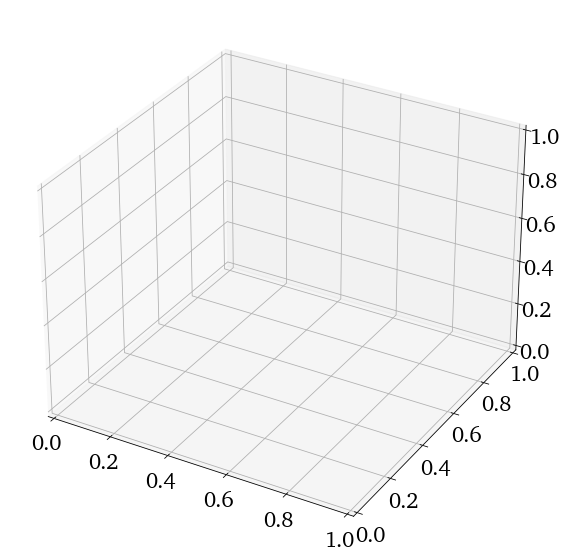

In [37]:
# %matplotlib qt

iVar    = 1

# fig = plt.figure()
# ax  = fig.add_subplot(projection='3d')
# ax.scatter(ICs[:,0], ICs[:,1], A[iVar,:], c='k')
# ax.set_xlabel(r'$\eta_{'+str(1)+'}$')
# ax.set_ylabel(r'$\eta_{'+str(2)+'}$')
# ax.set_zlabel(r'$\Psi_{'+str(iVar+1)+'}$')


fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(projection='3d')
ax.scatter(ICs[:,0], ICs[:,1], A[iVar,:], c='k')
ax.set_xlabel(r'$x_{0}$')
ax.set_ylabel(r'$v_{0}$')
ax.set_zlabel(r'$\alpha_{x_'+str(iVar+1)+'}$')

Text(0, 0.5, '$\\psi_{2}$')

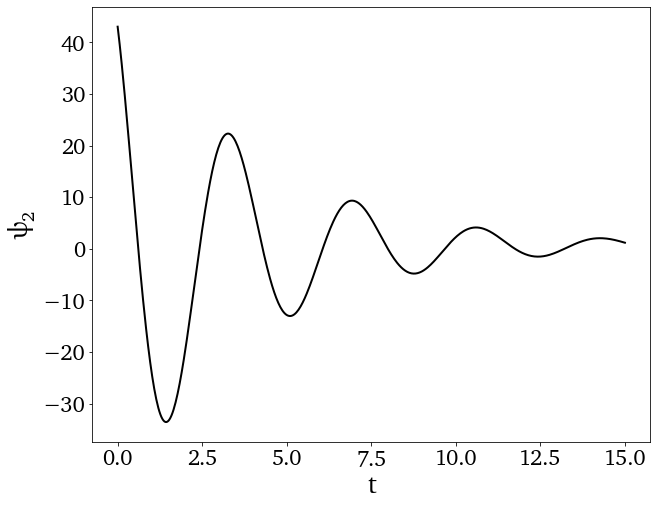

In [41]:
iVar = 1

plt.figure(figsize=(10,8))
plt.plot(tVec, yMat_pca[:,iVar], '-k')
plt.xlabel('t')
plt.ylabel(r'$\psi_{'+str(iVar+1)+'}$')
#plt.xscale('log')
#plt.xlim([1.e-6,1.e-4])

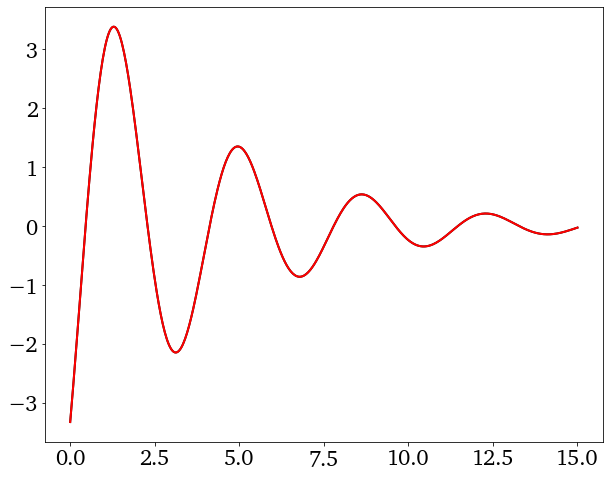

In [14]:
plt.figure(figsize=(10,8))
plt.plot(tVec, yMat[:,1], '-k')
plt.plot(tVec, yMat_[:,1], '-r')
#plt.xscale('log')

In [15]:
VarsPOD          = ['POD_'+str(iPOD+1) for iPOD in range(NPODsFinal)]
Data             = pd.DataFrame(yMat_pca, columns=VarsPOD)
#tVec[tVec == 0.] = FixedMinVal
Data['t']        = tVec
Data['log(t)']   = np.log(tVec)
Data['log10(t)'] = np.log10(tVec)


Data

/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,POD_1,POD_2,t,log(t),log10(t)
0,-0.364594,22.024017,0.00000,-inf,-inf
1,1.394683,21.634937,0.03006,-3.504556,-1.522009
2,3.120487,21.193435,0.06012,-2.811409,-1.220979
3,4.808674,20.701480,0.09018,-2.405944,-1.044888
4,6.455266,20.161147,0.12024,-2.118262,-0.919949
...,...,...,...,...,...
495,-0.968688,0.453453,14.87976,2.700002,1.172596
496,-0.932018,0.435088,14.90982,2.702020,1.173472
497,-0.896864,0.415797,14.93988,2.704034,1.174347
498,-0.863300,0.395646,14.96994,2.706044,1.175220


In [16]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME)
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/')
except:
    pass

In [17]:
data_id    = 'pts'

DataNoZero           = Data#[Data['t'] >= FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=ValidPerc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)


try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + VarsPOD]
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + VarsPOD]
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/Output.csv', index=False)

In [18]:
DataNoZero           = Data
n_points             = len(DataNoZero)

n_test               = n_points


try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + VarsPOD]
DataInput.to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + VarsPOD]
DataOutput.to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/Output.csv', index=False)

In [19]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME)
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/')
except:
    pass

In [20]:
data_id    = 'pts'

n_points             = len(DataIC)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=ValidPerc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)


try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/')
except:
    pass

DataInput  = DataIC
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/Input.csv', index=False)

DataOutput = pd.DataFrame(A.T, columns=['POD_'+str(i+1) for i in range(A.shape[0])])
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/Output.csv', index=False)

In [21]:
n_points             = len(DataIC)

n_test               = n_points

try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/')
except:
    pass

DataInput  = DataIC
DataInput.to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/Input.csv', index=False)

DataOutput = pd.DataFrame(A.T, columns=['POD_'+str(i+1) for i in range(A.shape[0])])
DataOutput.to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/Output.csv', index=False)